## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
import pyopenjtalk


/home/marukun_/git/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "/home/marukun_/.pyenv/versions/3.7.1/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/marukun_/.pyenv/versions/3.7.1/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/ipyk

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "models/ringo/checkpoint_29000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retriev

#### Prepare text input

In [6]:
input = "ごきげんよう。くじょうりんごだ。"
text = pyopenjtalk.g2p(input, kana=False).replace('pau',',').replace(' ','') + '.' + "\n"
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Downloading: "https://downloads.sourceforge.net/open-jtalk/open_jtalk_dic_utf_8-1.11.tar.gz"
Extracting tar file /home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/pyopenjtalk/dic.tar.gz


#### Decode text input and plot results

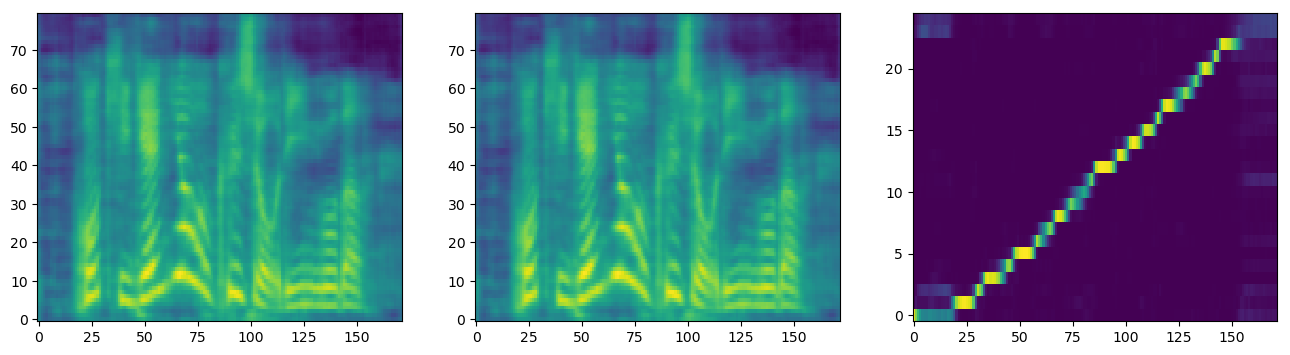

In [11]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [12]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
print(audio[0].data.cpu().numpy())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

[-0.00229111 -0.0019065  -0.00146042 ...  0.00010518  0.00014348
  0.00014115]


#### (Optional) Remove WaveGlow bias

In [13]:
import soundfile as sf

audio = waveglow.infer(mel_outputs_postnet, sigma=0.666);
sf.write('test.wav', audio[0].data.cpu().numpy().astype(np.float32), hparams.sampling_rate)

In [10]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

/home/marukun_/git/tacotron2/.venv/lib/python3.7/site-packages/librosa/util/utils.py:724: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mag = np.abs(S).astype(np.float)
